<a href="https://colab.research.google.com/github/MSU-ML-COURSE/private_DL_course_22/blob/main/%D0%A0%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D1%8F/%D0%97%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5%204/Homework_4_audio_SOLUTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Обучение нейронных сетей на аудио-данных

In [1]:
from IPython.display import clear_output
!pip uninstall -y torchaudio
!pip install --upgrade pip timm==0.4.5 torchaudio==0.11.0 librosa speechbrain
!wget https://www.dropbox.com/s/ca0b1v2nlxzyeb4/audioset_10_10_0.4593.pth
!wget https://github.com/karoldvl/ESC-50/archive/master.zip
!unzip master.zip
clear_output()

### Датасет


In [1]:
from scipy.io import wavfile
import IPython.display as ipd
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import librosa
import librosa.display
import io

def play_wav(file_path):
    samplerate, data = wavfile.read(file_path)
    pd.Series(data).plot(figsize=(10, 5), lw = 1)
    D = librosa.stft(data.astype(np.float32))
    S_db = librosa.amplitude_to_db(np.abs(D))
    fig, ax = plt.subplots(figsize=(10, 5))
    img = librosa.display.specshow(S_db,
                                x_axis='time',
                                y_axis='log',
                                ax=ax,
                                sr=samplerate)
    ax.set_title('Spectogram Example', fontsize=20)
    fig.colorbar(img, ax=ax, format=f'%0.2f')
    plt.show()
    ipd.display(ipd.Audio(data, rate=samplerate))

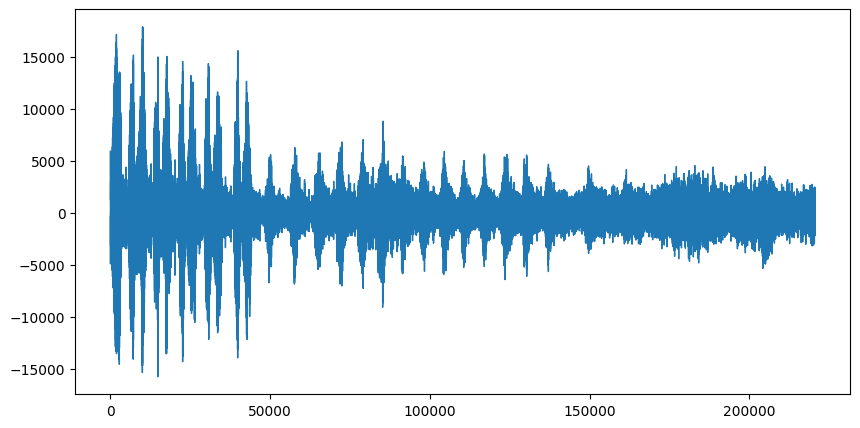

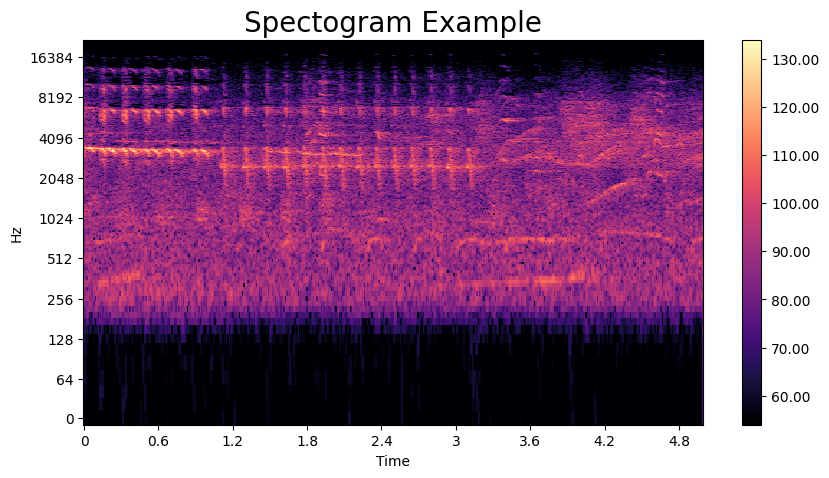

In [ ]:
play_wav('/content/ESC-50-master/audio/1-100038-A-14.wav')

## Подготовка датасета

Итак, теперь мы переходим непосредственно к подготовке датасета.

Для чтения файлов воспользуемся методом `torchaudio.load(filename)`, который возвращает два объекта: массив с измерениями и частоту семплирования.

Для того, чтобы изменить частоту аудио, мы воспользуемся torchaudio.transforms.Resample.


Классы каждого аудио могут быть найдены в файле `/content/ESC-50-master/meta/esc50.csv`, поэтому для каждого файла нам нужно запомнить соответствующее значение `target` (номер предсказываемого класса).

В качестве функции потерь мы воспользуемся функцией CrossEntropyLoss, который часто применяется в задачах классификации. Это означает для каждого объекта $x$ мы должны запомнить целевой вектор $y$ такой, что
\begin{align}
        y_i = \left\{
        \begin{array}{cl}
        0 & \text{, если объект } x \text{ не принадлежит к классу } i \\
        1 & \text{, если объект } x \text{ принадлежит к классу } i
        \end{array}
        \right.
    \end{align}
 Предсказывать, соответственно, мы также будем вектор (правдопободность отнесения объекта к каждому классу).

1. Заполним вспомогательный объект типа словарь (dict) `file2class` таким образом, чтобы значение `file2class[имя_файла]` было равно индексу класса, к которому отнесено аудио `имя_файkа`. Cчитать данные о классах аудио следует из файла `/content/ESC-50-master/meta/esc50.csv`.

1. Заполняем матрицы признаков и ответов X и y. Для этого вам пройдемся по всем файлам из папки `/content/ESC-50-master/audio` и для каждого файла:
    1. Прочитать файл в память при помощи `torchaudio.load(filename)`.
    1. Ресемплировать данные с использованием resampler(data).
    1. Посчитать банк фильтров для получившихся ресемплированных данных
    1. Поместить в список X получившийся фильтр банков, воспользовавшись функцией torchaudio.compliance.kaldi.fbank. Установите значение num_mel_bins=128 (то есть представить файл в виде последовательности векторов размерности 128), а также frame_shift=10 (размер окна).
    1. Построить целевой вектор для данного файла, который равен 1 в индексе, соответствующему индексу класса из `file2class`, и 0 в остальных позициях.
    1. Поместить получившийся целевой вектор в список y.
1. Разобъем данные на тренировочные, валидационные и тестовые данные.
- Разобъем сначала матрицы X и Y на обучение и тест при помощи train_test_split, воспользовавшись параметрами test_size=0.25 и random_state=0.
- Отделим от тренировочного датасета дополнительную часть для валидации, воспользовавшись test_size=0.10, random_state=0.

4. Создадим TensorDataset с тренировочными, валидационными и тестовыми данными. Немного `станадртизируем` признаки следующим образом:
 - из каждого признака вычтем его математическое ожидание (оценивается  как глобальное среднее по всему тренировочному датасету)
 - каждый признак разделите на его удвоенное стандартное отклонение (также считается как единственное глобальное значение)

Обычно исследователи делят на стандартное отклонение (т.е. используют StandardScaler из sklearn, но мы воспользуемся моделью из одной статьи, поэтому попытаемся полностью повторить все преобразования автора. 

In [3]:

import os
import csv
from pathlib import Path

from tqdm import tqdm

import numpy as np

from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

import torchaudio
from torchaudio.transforms import Resample
from torchaudio.compliance.kaldi import fbank


file2class = dict()
csv_file_path = '/content/ESC-50-master/meta/esc50.csv'


filename_array = []
target_array = []


with open(csv_file_path, 'r', newline='') as csvfile:
    csv_reader = csv.reader(csvfile)
    
    next(csv_reader, None)
    for row in csv_reader:
        filename_index = 0
        target_index = 2
        file2class[row[filename_index]] = row[target_index]
resampler = Resample(44100, 16000, dtype=torch.float32)
X, y = [], []

directory_path = '/content/ESC-50-master/audio'

for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)
    waveform, sample_rate = torchaudio.load(file_path)
    resampled_waveform = resampler(waveform)
    fbank_features = fbank(resampled_waveform, sample_rate, num_mel_bins=128, frame_shift=10)
    X.append(fbank_features.tolist())
    class_vec = [0] * 50
    class_vec[int(file2class[filename])] = 1

    y.append(class_vec)

train_and_valid_X, test_X, train_and_valid_y, test_y = train_test_split(X, y, test_size=0.25, random_state=0)
train_X, valid_X, train_y, valid_y = train_test_split(train_and_valid_X, train_and_valid_y, test_size=0.10, random_state=0)


torch_train_X = torch.Tensor(train_X)
torch_test_X = torch.Tensor(test_X)
torch_valid_X = torch.Tensor(valid_X)
math_expectation = torch_train_X.mean()
standard_deviation = torch_train_X.std()

train_dataset_tensor = TensorDataset((torch_train_X - math_expectation) / (2 * standard_deviation), torch.Tensor(train_y))
test_dataset_tensor = TensorDataset((torch_test_X - math_expectation) / (2 * standard_deviation), torch.Tensor(test_y))
valid_dataset_tensor = TensorDataset((torch_valid_X - math_expectation) / (2 * standard_deviation), torch.Tensor(valid_y))



Теперь подготовим три функции, которые нам потребуются для выполнения заданий.

Первая функция, которую мы должны реализовать, оценивает точность модели на некотором датасете. Соответственно, она принимает на вход некоторую модель model и произвольный датасет. Внутри данной функции мы должны получить выход модели модели, сконвертировать полученный вектор в предсказываемый класс для каждого объекта (это класс с наибольшим значением выхода), посчитать значение точности классификации  (accuracy_score) и вернуть его.

Вторая функция должна осуществлять обучение модели и оценивать её точность на валидационном датасете в конце каждой эпохи. Возвращать данная функция должна список со значениями точности на валидационном датасета в конце каждой эпохи.

Третья функция должна визуализировать качество нашей модели, а именно строить график значений точности и считать качество на всех датасетах, помещая результат в датафрейм.



### Реализация вспомогательных функций.

1. Реализуем функцию для оценки точности модели на данном датасете. Входные параметры данной модели следующие:
    - **Входные параметры функции:**
        - Оцениваемая модель
        - DataLoader для оценки
    - **Выход функции:**
        - Значение точности модели на данном датасете
    
2. Реализуем функцию для обучения модели.
    - **Входные параметры функции:**
        - DataLoader с тренировочным датасетом
        - DataLoader с валидационным датасетом
        - Обучаемая модель
        - Количество эпох обучения
        - Темп обучения (learning rate)
    - **Выход функции:**
        - Список со значениями точности модели на валидационном датасете в конце каждой эпохи
    - *Примерная реализация функции может быть описана следующим образом:*
        - Инициирование списка, в котором мы будем хранить значения точности на валидационном множестве
        - Инициализация оптимизатора с указанным темпом обучения (рекомендуется использовать `torch.optim.Adam`).
        - Инициализация функции потерь nn.CrossEntropyLoss()
        - Установку модель в состояние обучения
        - Осуществление эпохи обучения через полную итерацию по тренировочному датасету DataLoader с батчем указанного размера. Для каждого батча, как обычно, необходимо посчитать значение loss и осуществить шаг оптимизации. Также в конце эпохи сделайте torch.cuda.empty_cache(), чтобы было немного легче с памятью. Можете обернуть итерацию по эпохам в tqdm, чтобы видеть прогресс обучения.
        - Установку модели в состояние оценки
        - Вычисление значения точности (accuracy) на валидационном датасете и помещения его в соответствующий список.



3. Реализуем функцию для проверки модели и вывода метрик качества.
    - **Входные параметры функции:**
        - Dataloader с тренировочными датасетом
        - Dataloader с валидационным датасетом
        - Dataloader с тестовым датасетом

        - Обученная модель
        - Название модели (название должно быть понятным)
        - Список со значениями точности на валидационном множестве в ходе обучения (выход предыдущей функции)
        - Опционально: датафрейм с полями 'Model', 'Train Accuracy', 'Validation Accuracy', 'Test Accuracy', в который мы будем записывать результаты (если датафрейм не указан, то создаётся пустой датафрейм с указанными полями).
    - **Выход функции:**
        - Датафрейм с данными о качестве модели
    - *Процесс оценки модели должен содержать следующие шаги:*
        - Построение графика со значениями точности на валидационных данных в ходе обучения при помощи matplotlib или другой удобной библиотеки.
        - Вычисление значение точности для полученной модели на тренировочном, тестовом и валидационном наборах данных
        - Создание нового датафрейма или помещение в существующий значений метрик качества данной модели.
        - Вывод на экран текущего датафрейма



In [4]:
from sklearn.metrics import accuracy_score
from IPython.display import display
import pandas as pd
from torch.nn import Module
from typing import List
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

def calculate_accuracy_score(classifier: Module, dataloader: DataLoader) -> float:
        """
        Calculate accuracy score
        :param classifier: the classifier to use for predictions
        :param dataloader: the dataset to evaluate accuracy on
        :return: accuracy_score
        """
        classifier.eval()
        total_correct = 0
        total_samples = 0
        with torch.no_grad():
            for batch_data, batch_labels in dataloader:

                predictions = classifier(batch_data)
                
                nonzero_indices = torch.nonzero(batch_labels)
                batch_correct = (predictions.argmax(dim=1) == nonzero_indices[:, 1]).sum().item()
                num_nonzero_elements = nonzero_indices[:, 1]
                total_correct += batch_correct
                total_samples += len(batch_labels)
                return total_correct/total_samples

def train_model(train_dataloader: DataLoader, validation_dataloader: DataLoader, classifier: Module, epochs: int, learning_rate: float) -> List[float]:
        """
        The function to train the model
        :param      train_dataloader: the training dataset
        :param validation_dataloader: the validation dataset
        :param            classifier: the model to train
        :param                epochs: the number of training epoch
        :param         learning_rate: the value of learning rate used in optimizer
        :return: list with the accuracy values of the model on validation dataset at the end of every epoch
        """

        accuracy_list = []
        optimizer = optim.Adam(classifier.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            classifier.train()
            for batch_data, batch_labels in tqdm(train_dataloader, desc="Эпоха {}".format(epoch + 1), unit="батч", leave=False):
                optimizer.zero_grad()
                outputs = classifier(batch_data)  # Преобразуем входные данные в одномерный вектор
                loss = criterion(outputs, batch_labels)
                loss.backward() # Вычисляем градиенты функции потерь
                optimizer.step()
            torch.cuda.empty_cache()
            epoch_accuracy = calculate_accuracy_score(classifier, validation_dataloader)
            accuracy_list.append(epoch_accuracy)

        return accuracy_list


def evaluate_model(train_dataloader: DataLoader, validation_dataloader: DataLoader, test_dataloader: DataLoader, classifier: Module, model_name: str, accuracy_values: List[float], df: pd.DataFrame = None) -> pd.DataFrame:
        """
        The function to evaluate the model
        :param      train_dataloader: the training dataset
        :param validation_dataloader: the validation dataset
        :param       test_dataloader: the test dataset
        :param            classifier: the model to evaluate
        :param            model_name: the name of the model in the dataframe
        :param       accuracy_values: list with the accuracy values of the model on validation dataset at the end of every epoch
        :param                    df: the dataframe with the model accuracy on all three datasets
        :return: list with the accuracy values of the model on validation dataset at the end of every epoch
        """
        if df is None:
            df = pd.DataFrame(columns=['Model', 'Train Accuracy', 'Validation Accuracy', 'Test Accuracy'])

        #print('accuracy_values', accuracy_values)
        epochs = list(range(1, len(accuracy_values) + 1))
        plt.plot(epochs, np.array(accuracy_values) * 100 )
        plt.title(model_name  + ': accuracy durimg epochs (%)')
        plt.show()
        classifier.eval()
        train_accuracy = calculate_accuracy_score(classifier, train_dataloader)
        validation_accuracy = calculate_accuracy_score(classifier, validation_dataloader)
        test_accuracy = calculate_accuracy_score(classifier, test_dataloader)
        new_row = {'Model':model_name, 'Train Accuracy':train_accuracy * 100, 'Validation Accuracy':validation_accuracy * 100, 'Test Accuracy':test_accuracy * 100}
        df_new = df.append(new_row, ignore_index=True)

        display(df_new)
        return df_new

### Классификация аудио как изображения





Учтем, что свёртки в pytorch, даже conv2d, ВСЕГДА считают, что входные данные имеют каналы. В нашем случае во входных данных канал один и нам нужно явно показать это, сделав unsqueeze/reshape (к примеру, (9, 9) -> (1, 9, 9) или (число_батчей, N, M) -> (число_батчей, 1, N, M)).


План:
 Реализовать модель pytorch как nn.Module с применением сверток. Задайте этой модели следующую архитектуру:
    - На вход подаются созданные нами банки фильтров (или батч с ними)

    - сверточный двумерный слой с 1 входным каналом, 32 выходными и ядром 3 на 3
    - слой активации RELU
    - слой двумерной максимальной агрегации с ядром 2 и шагом (stride) 2
    - слой разреживания (Dropout)
    
    - сверточный двумерный слой с 32 входными каналами, 64 выходными и ядром 3 на 3
    - слой активации RELU
    - слой двумерной максимальной агрегации с ядром 2 и шагом (stride) 2
    - слой разреживания (Dropout)

    - сверточный двумерный слой с 64 входными каналами, 128 выходными и ядром 3 на 3
    - слой активации RELU
    - слой двумерной максимальной агрегации с ядром 2 и шагом (stride) 2
    - слой разреживания (Dropout)

    - полносвязный линейный слой (nn.Linear) который возвращает предсказания для получившихся данных


## Примерная схема модели:

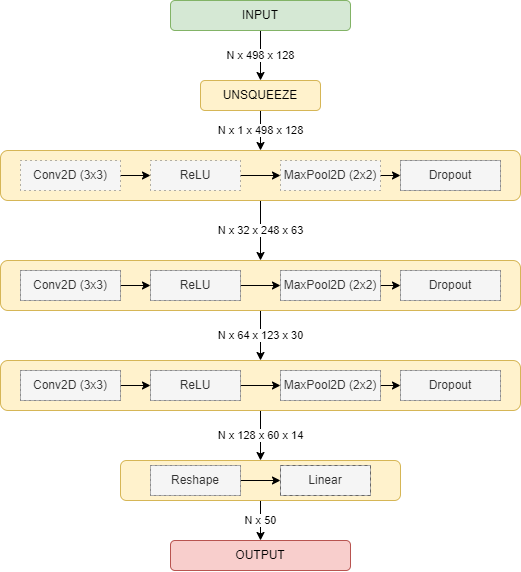

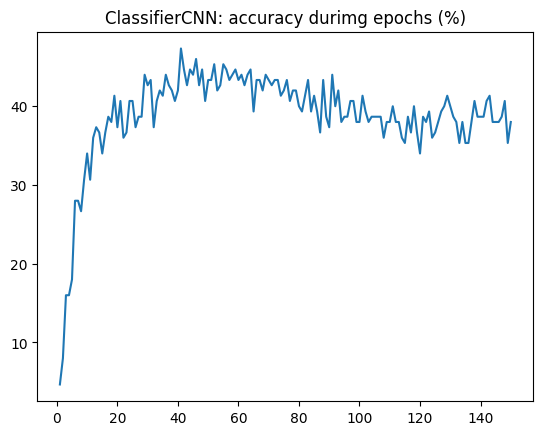

<ipython-input-4-9c8ddf3ce50d>:103: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df.append(new_row, ignore_index=True)


,Model,Train Accuracy,Validation Accuracy,Test Accuracy
0,ClassifierCNN,100.0,38.0,37.8


In [7]:
class ClassifierCNN(torch.nn.Module):

    def __init__(self):
        super(ClassifierCNN, self).__init__()
        
        self.classifierCNN = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Dropout2d(),
            nn.Conv2d(32, 64, kernel_size = 3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Dropout2d(),
            nn.Conv2d(64, 128, kernel_size = 3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Dropout2d(),
            nn.Flatten(),
            nn.Linear(128*60*14, 50))

    def forward(self, x):
        
        new_tensor = torch.unsqueeze(x, dim=1
                                    )
        #print(new_tensor.shape)
        return self.classifierCNN(new_tensor)

classifier = ClassifierCNN()
if torch.cuda.is_available():
    classifier = classifier.cuda()

batch_size = 50
learning_rate = 1e-4
epochs = 150
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


train_dataloader = (DataLoader(train_dataset_tensor, batch_size=batch_size, shuffle=False))
test_dataloader = (DataLoader(test_dataset_tensor, batch_size=batch_size, shuffle=False))
valid_dataloader = (DataLoader(valid_dataset_tensor, batch_size=batch_size, shuffle=False))
# train and evaluate the model here
train_dataloader_cuda = [(batch[0].to(device), batch[1].to(device)) for batch in train_dataloader]
test_dataloader_cuda = [(batch[0].to(device), batch[1].to(device)) for batch in test_dataloader]
valid_dataloader_cuda = [(batch[0].to(device), batch[1].to(device)) for batch in valid_dataloader]

accuracy_values = train_model(train_dataloader_cuda, valid_dataloader_cuda, classifier, epochs, learning_rate)
df = evaluate_model(train_dataloader_cuda, valid_dataloader_cuda, test_dataloader_cuda, classifier, 'ClassifierCNN', accuracy_values)